![](./resources/System_v1_custom_cropland.png)

**Table of contents**<a id='toc0_'></a>    
- [Before you start](#toc1_)    
- [Define a region of interest](#toc2_)    
- [Extract public training data](#toc3_)    
- [Define target classes](#toc4_)    
- [Extract required model inputs](#toc5_)    
- [Train custom classification model](#toc6_)    
- [Deploy custom model](#toc7_)    
- [Generate a map](#toc8_)  

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Before you start](#toc0_)

In order to run WorldCereal crop mapping jobs from this notebook, you need to create an account on the Copernicus Data Space Ecosystem (CDSE) registering [here](https://dataspace.copernicus.eu/). This is free of charge and will grant you a number of free openEO processing credits to continue this demo.

In [1]:
# TEMPORARY CELL

import sys
sys.path.append('/home/jeroendegerickx/git/worldcereal/worldcereal-classification/notebooks')
%load_ext autoreload
%autoreload 2

# <a id='toc2_'></a>[Define a region of interest](#toc0_)

When running the code snippet below, an interactive map will be visualized.
Click the Rectangle button on the left hand side of the map to start drawing your region of interest.
Currently, there is a maximum size of 250 km² for your area within this demo. Upon exceeding this limit, an error will be shown.
The widget will automatically store the coordinates of the last rectangle you drew on the map.


In [2]:
from worldcereal.utils.map import ui_map

map = ui_map()
map.show_map()

Map(center=[51.1872, 5.1154], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

2024-10-12 16:57:20.746 | INFO     | worldcereal.utils.map:handle_draw:13 - Your processing extent: (37.554018, -3.071952, 37.680361, -2.973213)
2024-10-12 16:57:20.840 | INFO     | worldcereal.utils.map:handle_draw:19 - Area of processing extent: 153.72 km²


# <a id='toc3_'></a>[Extract public training data](#toc0_)

Here we query existing reference data that have already been processed by WorldCereal and are ready to use.
To increase the number of hits, we expand the search area by 250 km in all directions.

In [3]:
from worldcereal.utils.refdata import query_public_extractions

# retrieve the polygon you just drew
polygon = map.get_polygon_latlon()

# Query our public database of training data
public_df = query_public_extractions(polygon, filter_cropland=False)
public_df.year.value_counts()

2024-10-12 16:57:28.207 | INFO     | worldcereal.utils.map:get_processing_extent:112 - Your processing extent: (37.554018, -3.071952, 37.680361, -2.973213)
2024-10-12 16:57:28.208 | INFO     | worldcereal.utils.refdata:query_public_extractions:51 - Applying a buffer of 250 km to the selected area ...
2024-10-12 16:57:28.380 | INFO     | worldcereal.utils.refdata:query_public_extractions:81 - Querying WorldCereal global extractions database (this can take a while) ...
2024-10-12 16:57:43.231 | INFO     | worldcereal.utils.refdata:process_parquet:127 - Processing selected samples ...
2024-10-12 16:57:44.619 | INFO     | worldcereal.utils.refdata:process_parquet:130 - Extracted and processed 10459 samples from global database.


year
2019    3318
2021    3297
2020    3187
2018     657
Name: count, dtype: int64

# <a id='toc4_'></a>[Define target classes](#toc0_)

Run the next cell and select all land cover classes you would like to include in your "cropland" class. All classes that are not selected will be grouped under the "other" category. 

In [4]:
# from utils import pick_croptypes
from utils import select_landcover
from IPython.display import display

checkbox, checkbox_widgets = select_landcover(public_df)
display(checkbox)

Based on your selection, a custom target label is now generated for each sample. Verify that only land cover classes of your choice are appearing in the `downstream_class`, all others will fall under `other`.

In [5]:
from utils import get_custom_cropland_labels

public_df = get_custom_cropland_labels(public_df, checkbox_widgets)
public_df["downstream_class"].value_counts()

downstream_class
other       8086
cropland    2373
Name: count, dtype: int64

# <a id='toc5_'></a>[Extract required model inputs](#toc0_)

Here we prepare presto inputs features for each sample by using a model pretrained on WorldCereal data. The resulting `encodings` and `targets` will be used for model training.

In [6]:
from utils import prepare_training_dataframe

training_dataframe = prepare_training_dataframe(public_df, task_type="cropland")

2024-10-12 16:59:55.084 | INFO     | utils:prepare_training_dataframe:314 - Presto URL: https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/models/PhaseII/presto-ss-wc-ft-ct_cropland_CROPLAND2_30D_random_time-token=none_balance=True_augment=True.pt


2024-10-12 16:59:55.272 | INFO     | worldcereal.train.data:__init__:35 - Augmentation is enabled.     The horizontal jittering of the selected window will be performed.
2024-10-12 16:59:55.274 | INFO     | worldcereal.train.data:__init__:51 - Original dataset size: 10459
2024-10-12 16:59:55.275 | INFO     | worldcereal.train.data:__init__:57 - Dataset size after 1 repeats: 10459
2024-10-12 16:59:55.276 | INFO     | utils:prepare_training_dataframe:330 - Computing Presto embeddings ...
100%|██████████| 41/41 [00:35<00:00,  1.16it/s]
2024-10-12 17:00:30.601 | INFO     | utils:prepare_training_dataframe:338 - Done.


# <a id='toc6_'></a>[Train custom classification model](#toc0_)
We train a catboost model for the selected crop types. Class weights are automatically determined to balance the individual classes.

In [9]:
from utils import train_cropland_classifier

custom_model, report, confusion_matrix = train_cropland_classifier(training_dataframe)

2024-10-12 17:02:06.581 | INFO     | utils:train_classifier:382 - Split train/test ...
2024-10-12 17:02:06.605 | INFO     | utils:train_classifier:401 - Computing class weights ...
2024-10-12 17:02:06.613 | INFO     | utils:train_classifier:414 - Class weights: {'cropland': 2.204, 'other': 0.647}
2024-10-12 17:02:06.652 | INFO     | utils:train_classifier:450 - Training CatBoost classifier ...


Learning rate set to 0.021674
0:	learn: 0.8889410	test: 0.8789516	best: 0.8789516 (0)	total: 84.3ms	remaining: 11m 14s
25:	learn: 0.9214067	test: 0.9120715	best: 0.9120715 (25)	total: 458ms	remaining: 2m 20s
50:	learn: 0.9330262	test: 0.9148994	best: 0.9151916 (44)	total: 827ms	remaining: 2m 8s
75:	learn: 0.9415866	test: 0.9184952	best: 0.9184952 (74)	total: 1.22s	remaining: 2m 7s
100:	learn: 0.9480570	test: 0.9198608	best: 0.9211268 (84)	total: 1.62s	remaining: 2m 6s
125:	learn: 0.9536091	test: 0.9199263	best: 0.9211268 (84)	total: 1.99s	remaining: 2m 4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9211267736
bestIteration = 84

Shrink model to first 85 iterations.


In [10]:
# Print the classification report
print(report)

              precision    recall  f1-score   support

    cropland       0.78      0.92      0.84       475
       other       0.97      0.92      0.95      1617

    accuracy                           0.92      2092
   macro avg       0.88      0.92      0.90      2092
weighted avg       0.93      0.92      0.92      2092



# <a id='toc7_'></a>[Deploy custom model](#toc0_)

Once trained, we have to upload our model to the cloud so it can be used for inference. Note that these models are only kept in cloud storage for a limited amount of time.


In [11]:
from worldcereal.utils.upload import deploy_model
from openeo_gfmap.backend import cdse_connection

model_url = deploy_model(cdse_connection(), custom_model, pattern="demo_cropland_TZA")

2024-10-12 17:02:54.665 | INFO     | worldcereal.utils.upload:deploy_model:205 - Deploying model ...


Authenticated using refresh token.


2024-10-12 17:02:56.096 | INFO     | worldcereal.utils.upload:deploy_model:211 - Deployed to: s3://OpenEO-artifacts/fd307620ba8a0a07c44a2dc28541b181d5c03cb4/2024/10/12/demo_cropland_TZA_custommodel.onnx


# <a id='toc8_'></a>[Generate a map](#toc0_)

Using our custom model, we generate a map for our region and season of interest.
To determine your season of interest, you can consult the WorldCereal crop calendars (by executing the next cell), or check out the [USDA crop calendars](https://ipad.fas.usda.gov/ogamaps/cropcalendar.aspx).

2024-10-12 17:03:53.786 | INFO     | worldcereal.utils.map:get_processing_extent:112 - Your processing extent: (37.554018, -3.071952, 37.680361, -2.973213)


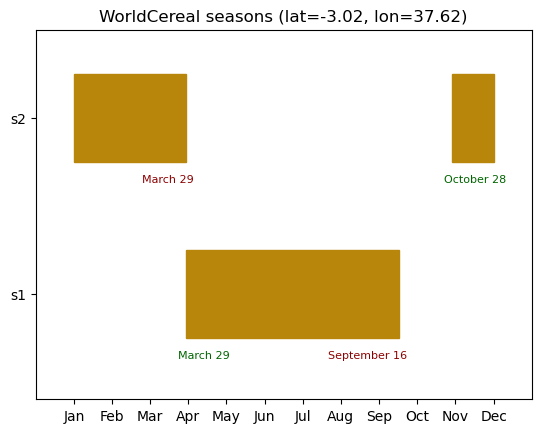

In [12]:
from utils import retrieve_worldcereal_seasons

spatial_extent = map.get_processing_extent()
seasons = retrieve_worldcereal_seasons(spatial_extent)

Now use the slider to select your processing period. Note that the length of the period is always fixed to a year.
Just make sure your season of interest is fully captured within the period you select.

In [13]:
from utils import date_slider

slider = date_slider()
slider.show_slider()

Set some other customization options:

In [14]:
from worldcereal.job import PostprocessParameters
import os
from pathlib import Path

# Choose whether or not you want to spatially clean the classification results (default = True)
postprocess_result = True
# Choose the postprocessing method you want to use ["smooth_probabilities", "majority_vote"] (default = "smooth_probabilities")
postprocess_method = "majority_vote"
# Additiona parameters for the majority vote method:
kernel_size = 3 # default = 5
# Do you want to save the intermediate results (before applying the postprocessing)
save_intermediate = True #default is False
# Do you want to save all class probabilities in the final product? (default is False)
keep_class_probs = True

postprocess_parameters = PostprocessParameters(enable=postprocess_result,
                                               method=postprocess_method,
                                               kernel_size=kernel_size,
                                               save_intermediate=save_intermediate,
                                               keep_class_probs=keep_class_probs)

# Specify the local directory where the resulting maps should be downloaded to.
output_dir = Path(os.getcwd()) / 'CROPLAND_custom_test'
print(f"Output directory: {output_dir}")

Output directory: /home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPLAND_custom_test


In [10]:
from worldcereal.job import generate_map, CropLandParameters

# Initializes default parameters
parameters = CropLandParameters()

# Change the URL to your custom classification model
parameters.classifier_parameters.classifier_url = model_url

# Get processing period and area
processing_period = slider.get_processing_period()
processing_extent = map.get_processing_extent()

# Launch the job
job_results = generate_map(
    processing_extent,
    processing_period,
    output_dir=output_dir,
    cropland_parameters=parameters,
    postprocess_parameters=postprocess_parameters,
)

Authenticated using refresh token.


2024-10-08 12:50:26,563 - openeo_gfmap.utils - INFO - Selected orbit state: DESCENDING. Reason: Orbit has more cumulative intersected area. 15.678082454846425 > 13.936101536993151


InvalidProtobuf: [ONNXRuntimeError] : 7 : INVALID_PROTOBUF : Failed to load model because protobuf parsing failed.

The classification results will be automatically downloaded to your output_dir in .tif format.
By default, OpenEO stores the class labels, confidence score and class probabilities in one file.

Using the function below, we split this information into separate .tif files, thereby adding metadata and a color map, to ease interpretation and visualization:
- "xxx_classification_start-date_end-date.tif" --> contains the classification labels. A class look-up table is included in the .tif metadata.
- "xxx_confidence_start-date_end-date.tif" -->  contains the probability associated to the prediction [0 - 100]

In case you chose to store the original per-class probabilities, these are NOT written to a separate file and need to be consulted in the original result downloaded from OpenEO.

In [ ]:
from utils import prepare_visualization

rasters = prepare_visualization(job_results)
print(rasters)

The resulting raster files can be visualized in QGIS, or using the function in the cell below...

In [ ]:
from utils import visualize_products

visualize_products(rasters, port=8887)

Finally, use the cell below to visualize the look-up table for the classification product.

In [ ]:
from utils import show_color_legend

show_color_legend(rasters, "cropland")